In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import cv2
import numpy as np
import sys
import itertools
import os
import shutil
import random
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
print("Importing complete")

Importing complete


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if len(physical_devices)!=0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [ ]:
!rm -rf ./logs/ 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**`Dataset Generation**

In [ ]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!unzip -u '/content/gdrive/My Drive/Drowsiness_Detection/data1.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/data 1/valid/Closed_Eyes/closed_eyes_22447.png  
  inflating: /content/dataset/data 1/valid/Closed_Eyes/closed_eyes_22450.png  
  inflating: /content/dataset/data 1/valid/Closed_Eyes/closed_eyes_22451.png  
  inflating: /content/dataset/data 1/valid/Closed_Eyes/closed_eyes_22452.png  
  inflating: /content/dataset/data 1/valid/Closed_Eyes/closed_eyes_22454.png  
  inflating: /content/dataset/data 1/valid/Closed_Eyes/closed_eyes_22455.png  
  inflating: /content/dataset/data 1/valid/Closed_Eyes/closed_eyes_22458.png  
  inflating: /content/dataset/data 1/valid/Closed_Eyes/closed_eyes_22476.png  
  inflating: /content/dataset/data 1/valid/Closed_Eyes/closed_eyes_22477.png  
  inflating: /content/dataset/data 1/valid/Closed_Eyes/closed_eyes_2248.png  
  inflating: /content/dataset/data 1/valid/Closed_Eyes/closed_eyes_22498.png  
  inflating: /content/dataset/data 1/valid/Closed_Eyes/closed_eyes_22499.png  
  

In [ ]:
# import os
# import random
# import shutil

# os.chdir('/content/dataset')
# if os.path.isdir('train/Open_Eyes/') is False:
#     os.mkdir('train')
#     os.mkdir('valid')
#     os.mkdir('test')

#     for i in ["Open_Eyes","Closed_Eyes"]:
#         shutil.move(f'{i}','train')
#         os.mkdir(f'valid/{i}')
#         os.mkdir(f'test/{i}')

#         temp = int(0.15*len(os.listdir(f'train/{i}')))

#         valid_samples = random.sample(os.listdir(f'train/{i}'), temp)
#         for j in valid_samples:
#             shutil.move(f'train/{i}/{j}', f'valid/{i}')

#         test_samples = random.sample(os.listdir(f'train/{i}'), temp)
#         for k in test_samples:
#             shutil.move(f'train/{i}/{k}', f'test/{i}')
# os.chdir('../..')

In [ ]:
train_path = '/content/dataset/data 1/train'
valid_path = '/content/dataset/data 1//valid'
test_path = '/content/dataset/data 1//test'

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path,class_mode='binary',classes=['Closed_Eyes','Open_Eyes'], target_size=(224,224))
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path,class_mode='binary',classes=['Closed_Eyes','Open_Eyes'], target_size=(224,224))
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, class_mode='binary',classes=['Closed_Eyes','Open_Eyes'],target_size=(224,224),shuffle = False )

Found 33022 images belonging to 2 classes.
Found 7075 images belonging to 2 classes.
Found 7075 images belonging to 2 classes.


**Model Creation**

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

 **Fine Tuning and Transfer Learning**

In [ ]:
base_input = mobile.layers[0].input
base_output = mobile.layers[-4].output

In [ ]:
Flat_layer = keras.layers.Flatten()(base_output)
dense_layer = keras.layers.Dense(1)(Flat_layer)
final_output = keras.layers.Activation('sigmoid')(dense_layer)

In [ ]:
model =Model(inputs = base_input,outputs = final_output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

**Model Training**

In [ ]:
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, shuffle = True,callbacks=[tensorboard_callback])

Epoch 1/10
1032/1032 [==============================] - 311s 269ms/step - loss: 0.0773 - accuracy: 0.9767 - val_loss: 0.0409 - val_accuracy: 0.9881
Epoch 2/10
1032/1032 [==============================] - 275s 267ms/step - loss: 0.0257 - accuracy: 0.9917 - val_loss: 0.0456 - val_accuracy: 0.9860
Epoch 3/10
1032/1032 [==============================] - 274s 266ms/step - loss: 0.0206 - accuracy: 0.9930 - val_loss: 0.0323 - val_accuracy: 0.9884
Epoch 4/10
1032/1032 [==============================] - 276s 267ms/step - loss: 0.0185 - accuracy: 0.9935 - val_loss: 0.0329 - val_accuracy: 0.9886
Epoch 5/10
1032/1032 [==============================] - 275s 267ms/step - loss: 0.0192 - accuracy: 0.9936 - val_loss: 0.0291 - val_accuracy: 0.9905
Epoch 6/10
1032/1032 [==============================] - 275s 266ms/step - loss: 0.0180 - accuracy: 0.9943 - val_loss: 0.0243 - val_accuracy: 0.9901
Epoch 7/10
1032/1032 [==============================] - 275s 267ms/step - loss: 0.0146 - accuracy: 0.9953 - val_

**Model Testing**

In [ ]:
# def plotImages(images_arr):
#   fig, axes = plt.subplots(1,10,figsize=(20,20))
#   axes = axes.flatten()
#   for img, ax in zip(images_arr,axes):
#     ax.imshow(img)
#     ax.axis('off')
#   plt.tight_layout()
#   plt.show()

In [ ]:
test_imgs, test_labels = next(test_batches)
# plotImages(test_imgs)
# print(test_labels)

In [ ]:
# test_batches.classes

In [ ]:
predictions = model.predict(x=test_batches,verbose=0)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes,y_pred=np.round(predictions))

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

  plt.imshow(cm, interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',color='white' if cm[i, j] > thresh else 'black')
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


In [ ]:
test_batches.class_indices

{'Closed_Eyes': 0, 'Open_Eyes': 1}

Confusion matrix, without normalization
[[4541   30]
 [  42 2462]]


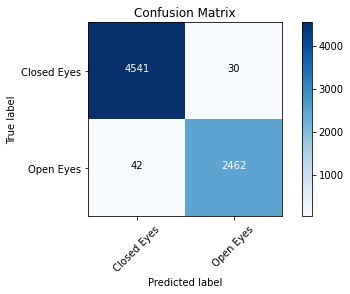

In [ ]:
# Train the model for more epochs to see better results
cm_plot_labels = ['Closed Eyes','Open Eyes']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
model.save('/content/gdrive/My Drive/Drowsiness_Detection/trained_models/model6.h5')

**Loading the model**

In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model('/content/gdrive/My Drive/Drowsiness_Detection/trained_models/model3.h5')

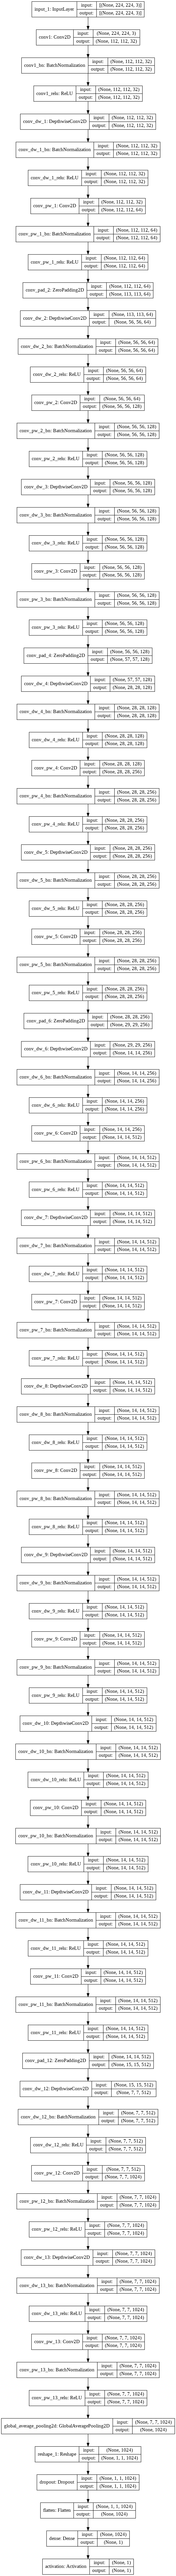

In [ ]:
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(new_model, to_file='/content/gdrive/My Drive/Drowsiness_Detection/trained_models/model_plot.png', show_shapes=True, show_layer_names=True)